[*********************100%%**********************]  1 of 1 completed


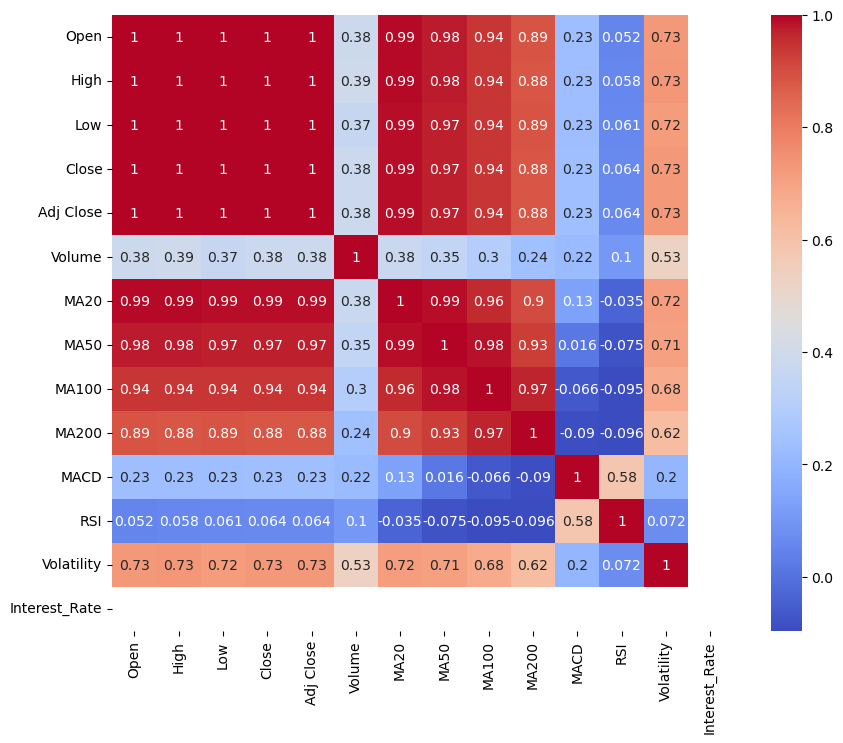

Epoch 1/10


C:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.0606
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0037
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0035
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0030
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0033
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0032
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0035
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0024
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0028
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0029
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


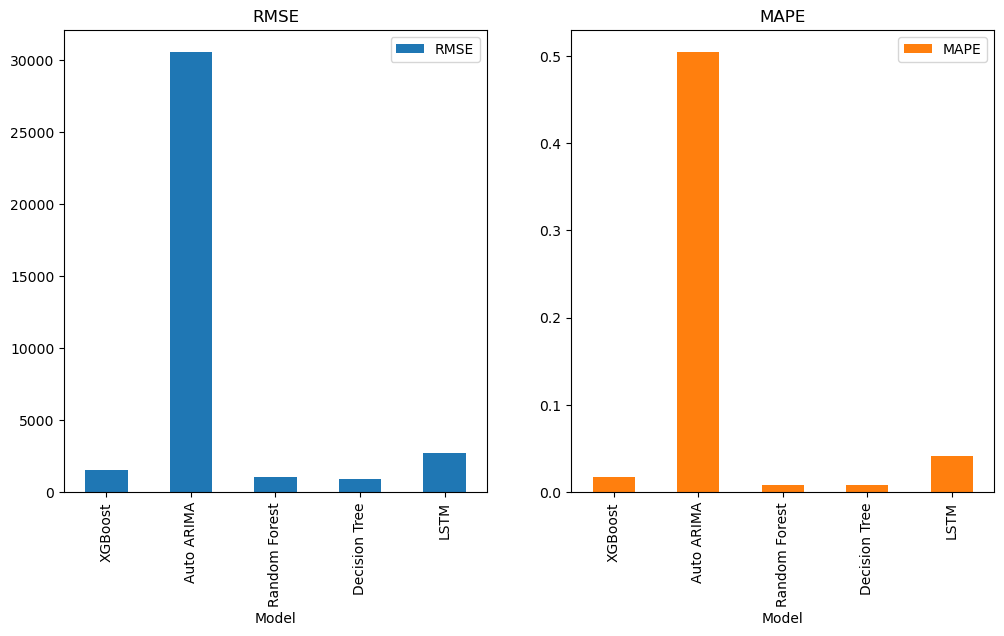

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Bitcoin prices for tomorrow:
XGBoost: $69283.20
Auto ARIMA: $69289.27
Random Forest: $69299.67
Decision Tree: $69289.27
LSTM: $67271.58


C:\Users\PC\AppData\Local\Temp\ipykernel_6620\2071160672.py:158: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Auto ARIMA": models["Auto ARIMA"].predict(n_periods=1)[0],
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\PC\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


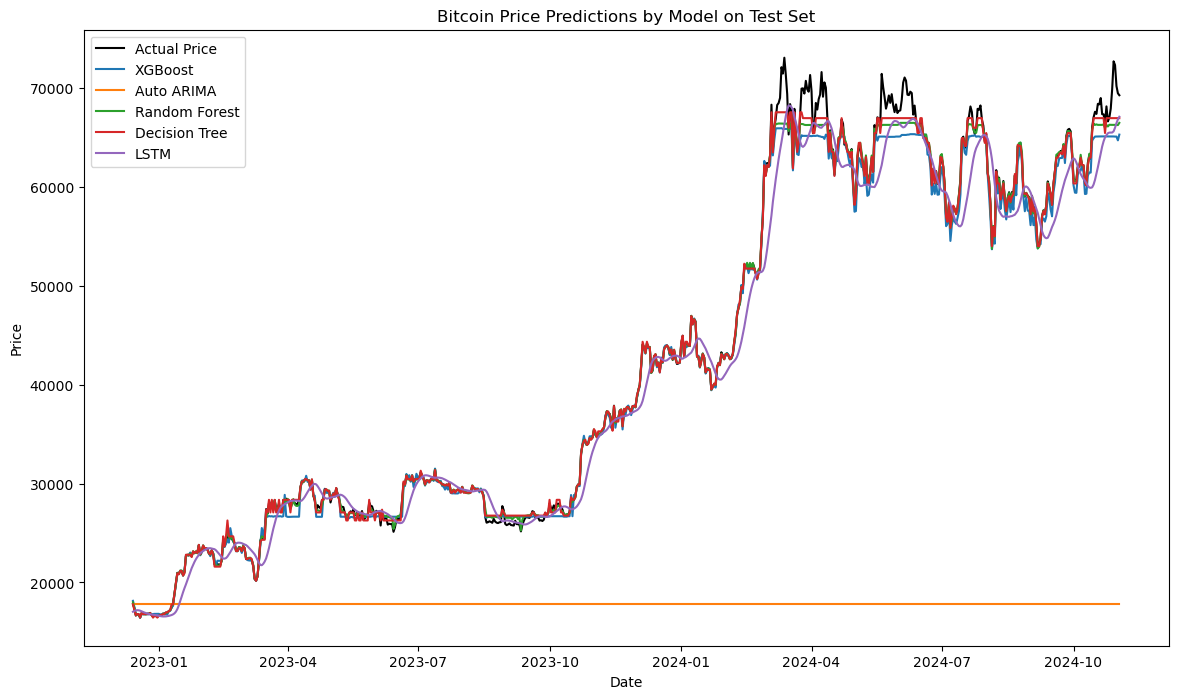

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Step 1: Download Bitcoin data
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
bitcoin_data = yf.download("BTC-USD", start=start_date, end=end_date)

# Add technical indicators
bitcoin_data['MA20'] = bitcoin_data['Close'].rolling(window=20).mean()
bitcoin_data['MA50'] = bitcoin_data['Close'].rolling(window=50).mean()
bitcoin_data['MA100'] = bitcoin_data['Close'].rolling(window=100).mean()
bitcoin_data['MA200'] = bitcoin_data['Close'].rolling(window=200).mean()
bitcoin_data['MACD'] = bitcoin_data['Close'].ewm(span=12).mean() - bitcoin_data['Close'].ewm(span=26).mean()
bitcoin_data['RSI'] = 100 - (100 / (1 + bitcoin_data['Close'].diff(1).clip(lower=0).rolling(window=14).mean() /
                                        bitcoin_data['Close'].diff(1).clip(upper=0).abs().rolling(window=14).mean()))
bitcoin_data['Volatility'] = bitcoin_data['Close'].rolling(window=20).std()

# Add economic indicators (dummy example, replace with real data)
bitcoin_data['Interest_Rate'] = 0.05  # Example fixed rate; replace with real data

# Dropping NaN values caused by rolling windows
bitcoin_data = bitcoin_data.dropna()

# Step 2: Calculate Correlation Matrix and Select Features
correlation_matrix = bitcoin_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

# Select features with high correlation to the target (Close price)
selected_features = correlation_matrix['Close'][abs(correlation_matrix['Close']) > 0.5].index.tolist()
selected_features.remove('Close')  # Remove target itself

# Data Preparation for ML models
X = bitcoin_data[selected_features]
y = bitcoin_data['Close']

# Splitting for Walk-forward validation
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Machine Learning Models
models = {
    "XGBoost": XGBRegressor(),
    "Auto ARIMA": auto_arima(y_train, seasonal=False, stepwise=True),
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor()
}

# Walk-forward validation for Machine Learning models
predictions = {}
metrics = {'Model': [], 'RMSE': [], 'MAPE': []}

# Non-LSTM model predictions and evaluation on walk-forward test set
for model_name, model in models.items():
    if model_name == "Auto ARIMA":
        model.fit(y_train)
        preds = model.predict(n_periods=len(y_test))
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    # Store predictions and calculate RMSE and MAPE
    predictions[model_name] = preds
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mape = mean_absolute_percentage_error(y_test, preds)
    metrics['Model'].append(model_name)
    metrics['RMSE'].append(rmse)
    metrics['MAPE'].append(mape)

# Preparing data for LSTM with a 360-day sequence length
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(y.values.reshape(-1, 1))
sequence_length = 360

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_data, sequence_length)
X_train_lstm, X_test_lstm = X_lstm[:train_size-sequence_length], X_lstm[train_size-sequence_length:]
y_train_lstm, y_test_lstm = y_lstm[:train_size-sequence_length], y_lstm[train_size-sequence_length:]

# Reshaping for LSTM input
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Define and train the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

# Make predictions with LSTM
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled).flatten()

# Store LSTM predictions and calculate RMSE and MAPE
predictions["LSTM"] = lstm_predictions

# Ensure y_test_adjusted matches lstm_predictions length
lstm_predictions_length = len(lstm_predictions)
y_test_adjusted = y_test.iloc[-lstm_predictions_length:]  # Slice the last part of y_test to match LSTM predictions

# Calculate RMSE and MAPE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_adjusted, lstm_predictions))
lstm_mape = mean_absolute_percentage_error(y_test_adjusted, lstm_predictions)
metrics['Model'].append("LSTM")
metrics['RMSE'].append(lstm_rmse)
metrics['MAPE'].append(lstm_mape)

# Plot RMSE and MAPE
metrics_df = pd.DataFrame(metrics)
metrics_df.plot(kind='bar', x='Model', y=['RMSE', 'MAPE'], subplots=True, layout=(1, 2), figsize=(12, 6))
plt.show()

# Train each model on the entire dataset for final prediction
models["XGBoost"].fit(X, y)
models["Random Forest"].fit(X, y)
models["Decision Tree"].fit(X, y)
models["Auto ARIMA"].fit(y)  # Auto ARIMA only requires the target variable

# Prepare the last row of features for prediction
last_row = X.iloc[-1, :].values.reshape(1, -1)  # Last available data point for feature-based models

# Prepare LSTM for next-day prediction using last 360 days
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))
lstm_next_day_scaled = lstm_model.predict(last_sequence)
lstm_next_day_price = scaler.inverse_transform(lstm_next_day_scaled)[0, 0]

# Predictions for the next day using all models
predictions_next_day = {
    "XGBoost": models["XGBoost"].predict(last_row)[0],
    "Auto ARIMA": models["Auto ARIMA"].predict(n_periods=1)[0],
    "Random Forest": models["Random Forest"].predict(last_row)[0],
    "Decision Tree": models["Decision Tree"].predict(last_row)[0],
    "LSTM": lstm_next_day_price
}

# Print the predicted prices for tomorrow
print("Predicted Bitcoin prices for tomorrow:")
for model_name, prediction in predictions_next_day.items():
    print(f"{model_name}: ${prediction:.2f}")

# Plot Predictions for Test Set
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label="Actual Price", color='black')
for name, preds in predictions.items():
    if name != "Auto ARIMA":
        plt.plot(y_test.index, preds, label=name)
    else:
        plt.plot(y_test.index, preds[:len(y_test)], label=name)
plt.legend()
plt.title("Bitcoin Price Predictions by Model on Test Set")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


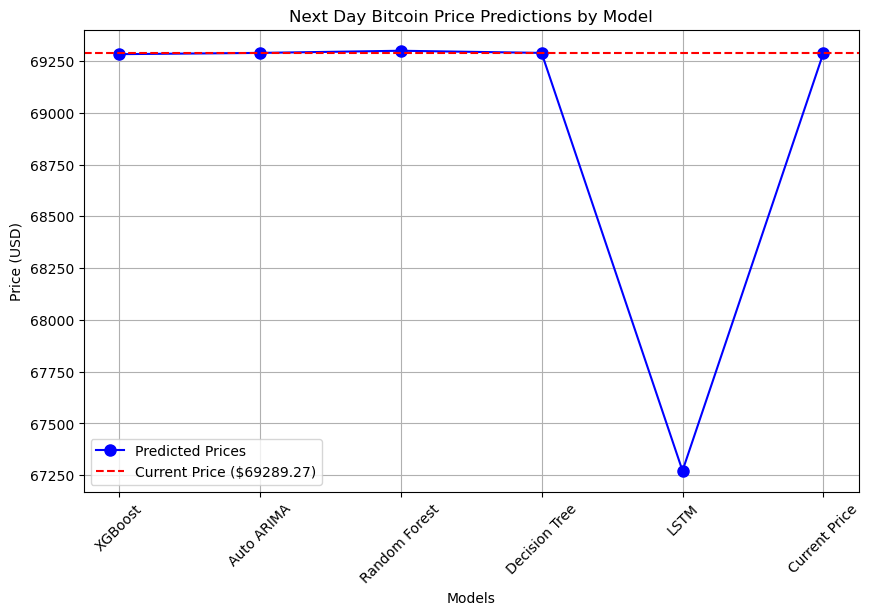

In [26]:
import matplotlib.pyplot as plt

# Get the current price
current_price = bitcoin_data['Close'].iloc[-1]

# Extract predictions from each model
model_names = list(predictions_next_day.keys())
predicted_prices = list(predictions_next_day.values())

# Add the current price to the plot for reference
model_names.append("Current Price")
predicted_prices.append(current_price)

# Plotting the predictions
plt.figure(figsize=(10, 6))
plt.plot(model_names, predicted_prices, 'o-', color='b', markersize=8, label='Predicted Prices')
plt.axhline(y=current_price, color='r', linestyle='--', label=f'Current Price (${current_price:.2f})')

# Add labels and title
plt.title("Next Day Bitcoin Price Predictions by Model")
plt.xlabel("Models")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [24]:
# Example MAPE values for each model (from the metrics DataFrame)
# Ensure these are in the same order as predictions_next_day
mape_values = metrics_df.set_index('Model')['MAPE'].to_dict()

# Convert MAPE values to weights (inverse of MAPE)
weights = {model: 1 / mape_values[model] for model in predictions_next_day.keys()}

# Calculate the weighted average prediction
weighted_sum = sum(weights[model] * predictions_next_day[model] for model in predictions_next_day)
total_weight = sum(weights.values())
average_prediction = weighted_sum / total_weight

# Current Bitcoin price
current_price = bitcoin_data['Close'].iloc[-1]

# Buy/Sell/Hold Signal based on weighted average prediction
if average_prediction > current_price:
    print("Signal: Buy - Average predicted price is higher than current price.")
elif average_prediction < current_price:
    print("Signal: Sell - Average predicted price is lower than current price.")
else:
    print("Signal: Hold - Predicted price is close to the current price.")


Signal: Sell - Average predicted price is lower than current price.
